Assignment:4
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

submission deadline till 9pm friday

submission instruction:
create your github repo and keep all the assisgnments over there(in that github repo)
i will share one googleform in group after completing your assignment you can share the github link through that google form. 

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['GOOGLE_API_KEY'] = os.getenv("GOOGLE_API_KEY")
os.environ['OPENWEATHER_API_KEY'] = os.getenv("OPENWEATHER_API_KEY")


## Sample Graph

In [2]:
from typing import TypedDict, Annotated, Sequence, Any
from langchain_core.messages import BaseMessage
import operator


In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    crawler_response: Any

### Router Function

In [4]:
def router_function(state:AgentState):
    """
    Not enough context? → Call LLM.
    Need attractions & local insights? → RAG node.
    Need live events/hotels/weather? → Web Crawler.
    """
    print("-> ROUTER ->")

    last_message=state["messages"][-1].lower()
    print("last_message:", last_message)
    
    if "latest" in last_message or "weather" in last_message:
        return "WEB"
    elif "attractions" in last_message or "historical" in last_message:
        return "RAG"
    else:
        return "LLM"




### RAG Node

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser


# retriever , prompt , model , output parser

def get_retriever():

    # Text splitter
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=20,
        chunk_overlap=5
        )
    print("text_splitter: ", text_splitter)
    
    # Loader
    # , "./*.pdf"
    loader=DirectoryLoader("travel_files",
                           glob=["./*.txt"],loader_cls=TextLoader)
    print("loader: ", loader)
    docs=loader.load()
    print("docs: ", docs)

    new_docs=text_splitter.split_documents(documents=docs)

    # embeddings
    embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
    db=Chroma.from_documents(new_docs,embeddings)

    # retriever
    retriever=db.as_retriever(search_kwargs={"k": 3})
    return retriever

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def get_prompt(question=""):
    prompt=PromptTemplate(
        template="""You are a travel assistant.
        Create a detailed travel plan based on the following request.
        Include the best places to visit, suggested itinerary (day-wise), 
        transportation tips, and local food recommendations.
        Make it engaging and personalized.
        User Request: {question}""",
        
        input_variables=['question']
    )
    return prompt

def get_model():
    model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
    return model

model = get_model()

retriever = get_retriever()

def rag_function_3(state:AgentState):
    print("-> RAG Call ->")
    question = state["messages"][0]

    print("question: ", question)
    prompt = get_prompt(question=question)
 


    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    print("rag_chain: ", rag_chain)
    
    result = rag_chain.invoke(question)
    print("result: ", result)

    return  {"messages": [result]}



text_splitter:  <langchain_text_splitters.character.RecursiveCharacterTextSplitter object at 0x0000028F6D4CFE90>
loader:  <langchain_community.document_loaders.directory.DirectoryLoader object at 0x0000028F0619D510>
docs:  [Document(metadata={'source': 'travel_files\\munnar_itinerary.txt'}, page_content='Munnar 3-Day Itinerary\n\nDay 1:\n- Arrival at Munnar\n- Visit to Tea Museum\n- Walk through tea plantations\n\nDay 2:\n- Eravikulam National Park\n- Mattupetty Dam\n- Kundala Lake\n- Echo Point\n\nDay 3:\n- Top Station viewpoint\n- Local market for souvenirs\n- Departure\n')]


c:\Users\Chiru\anaconda3\envs\agentic_ai_base2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Supervisor

In [6]:
from pydantic import BaseModel , Field

class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [7]:
from langchain.output_parsers import PydanticOutputParser
parser1=PydanticOutputParser(pydantic_object=TopicSelectionParser)
# parser.get_format_instructions()

def supervisor_function_1(state:AgentState):
    question=state["messages"][-1]
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [LLM, RAG, WEB]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser1.get_format_instructions()}
    )
    
    chain= prompt | model | parser1
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}





In [8]:
question="I want to visit munnar for 3 days only if the weather is pleasure in munnar"
format_instructions=parser1.get_format_instructions()
template="""Your task is to classify the given user query into one of the following categories: [LLM, RAG, WEB].  
Only respond with the category name and nothing else.
User query: {question}
{format_instructions}
"""

In [9]:
template

'Your task is to classify the given user query into one of the following categories: [LLM, RAG, WEB].  \nOnly respond with the category name and nothing else.\nUser query: {question}\n{format_instructions}\n'

In [10]:
prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser1.get_format_instructions()}
    )
prompt

PromptTemplate(input_variables=['question'], input_types={}, partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'}, template='Your task is to classify the given user query into one of the following categories: [LLM, RAG, WEB].  \nOnly respond with the category name and nothing else.\nUser query: {question}

In [11]:
chain= prompt | model | parser1


In [12]:
response = chain.invoke({"question":question})

In [13]:
response.Topic

'WEB'

### LLM Node

In [14]:
# LLM Function

def llm_function_2(state:AgentState):
    print("-> 1 LLM Call ->")
    question = state["messages"][0]
    
    print("question: ", question)
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    print("complete_query: ", complete_query)


    response = model.invoke(complete_query)
    print("-> 2 LLM Call ->")

    return {"messages": [response.content]}

### WEB Node

In [15]:
# WEB Crawler Function
from langchain_community.tools import DuckDuckGoSearchRun
import requests
import os

def fetch_weather(location):
    print("Location: ", location)
    API_KEY = os.getenv("OPENWEATHER_API_KEY")

    url = f"https://api.openweathermap.org/data/2.5/weather?q={location}&appid={API_KEY}&units=metric"
    try:
        res = requests.get(url)
        data = res.json()
        desc = data["weather"][0]["description"]
        temp = data["main"]["temp"]
        return f"{desc}, {temp}°C"
    except:
        return "Weather info not available"


def web_function_4(state:AgentState):
    """
    finds the location from from given string.
    """
    location =state.get("query", "").split("to")[-1].strip()  # crude location extraction

    weather = fetch_weather(location)

    state["crawler_response"] = "WEB RESULTS"

    return state

### Validate Node

In [16]:

def validate_function_5(state:AgentState):
    """
    Validates the code
    """
    return state

### Graph

In [17]:
from langgraph.graph import StateGraph,END,START

workflow=StateGraph(AgentState)

workflow.add_node("Supervisor",supervisor_function_1)
workflow.add_node("LLM Call",llm_function_2)
workflow.add_node("RAG Call",rag_function_3)
workflow.add_node("WEB Call",web_function_4)
workflow.add_node("Validator",validate_function_5)

workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
    "Supervisor",
    router_function,
    {
        "LLM": "LLM Call",
        "RAG": "RAG Call",
        "WEB": "WEB Call"
    }
)

workflow.add_edge("LLM Call","Validator")
workflow.add_edge("RAG Call","Validator")
workflow.add_edge("WEB Call","Validator")
workflow.add_edge("Validator","Supervisor")

workflow.set_finish_point("Validator")
app=workflow.compile()


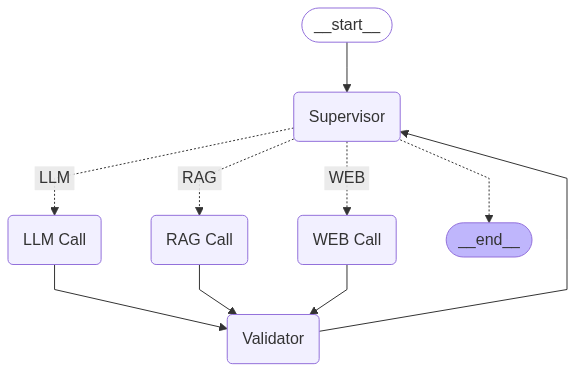

In [18]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Execution

In [19]:
app.invoke({"messages":["I want to visit munnar for 3 days only if the weather is pleasure in munnar"]})

Question I want to visit munnar for 3 days only if the weather is pleasure in munnar


OutputParserException: Invalid json output: WEB
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 